# Notebook to create training samples through data augmentation

In [1]:
import os
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, decimate
from obspy import read
from tqdm import tqdm
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import pickle
from collections import Counter

### Auxiliar functions

In [2]:
def bandfilt(tr, lower_cutoff=10, upper_cutoff=45, filter_order = 4):
    ''' Filter the trace using a bandpass filter.
    '''
    sr = tr.stats.sampling_rate
    tr_filt = tr
    nyquist_frequency = sr / 2
    b, a = butter(filter_order, [lower_cutoff / nyquist_frequency, upper_cutoff / nyquist_frequency], btype='band')
    tr_filt_data = filtfilt(b, a, tr.data)
    tr_filt = tr.copy()
    tr_filt.data = tr_filt_data

    return tr_filt

In [3]:
def resample(tr, target_sr = 100):
    ''' Resample the trace to a target sampling rate.
    '''
    factor = round(tr.stats.sampling_rate / target_sr)
    tr.decimate(factor=factor, strict_length=False, no_filter=True)

    return tr, factor

In [4]:
def homogenizer(tr, target_sr=100, target_filt = [10, 45], print_details=False):
    '''Receives a trace and resample it in case sampling rate is different from target sampling rate, also apply a filter to the trace.
    '''
    sr = tr.stats.sampling_rate
    if sr > target_sr + 1 or sr < target_sr - 1: # if sampling rate is not target_sr
        tr, factor = resample(tr, target_sr=target_sr) # antialiasing filter
        if print_details:
            print(f'Resampled from {sr} Hz to {target_sr} Hz.')
            print(f'Decimation factor: {factor}')
            print(f'New sampling rate: {tr.stats.sampling_rate}')
            print('\n')
    tr = bandfilt(tr, lower_cutoff=target_filt[0], upper_cutoff=target_filt[1]) # antialiasing filter
    tr = tr.normalize()

    return tr

### Source datasets

In [5]:
data_path = '/home/data'

noise_path = data_path  + "/NoiseSegs"
whale_call_path = data_path + "/WhaleCalls"
true_negative_path = data_path + "/SeisSegs"

ls_noise = os.listdir(noise_path)
ls_whale_call = os.listdir(whale_call_path)
ls_true_negative = os.listdir(true_negative_path)

print('Whale calls: ', len(ls_whale_call))
print('Noise: ', len(ls_noise))
print('True negatives: ', len(ls_true_negative))

Whale calls:  8814
Noise:  15000
True negatives:  5018


In [6]:
ls_noise

['2015_02_12_05_45_00_VA52.sac',
 '2015_02_15_18_06_00_NG63.sac',
 '2015_02_15_21_39_30_NG57.sac',
 '2015_02_12_23_54_30_VA45.sac',
 '2015_02_15_15_15_00_VA45.sac',
 '2015_02_12_22_53_00_NG75.sac',
 '2015_02_08_12_53_30_VA64.sac',
 '2015_02_12_21_06_30_NG40.sac',
 '2015_02_08_17_24_30_NG75.sac',
 '2015_02_12_03_22_30_VA45.sac',
 '2015_02_09_02_46_00_NG63.sac',
 '2015_02_15_16_36_00_NG75.sac',
 '2015_02_12_07_52_00_VA64.sac',
 '2015_02_08_18_09_30_NG44.sac',
 '2015_02_15_17_31_30_VA45.sac',
 '2015_02_08_14_07_30_VA45.sac',
 '2015_02_12_12_15_00_NG63.sac',
 '2015_02_12_15_05_30_VA52.sac',
 '2015_02_08_20_41_30_VA64.sac',
 '2015_02_12_13_14_30_NG40.sac',
 '2015_02_12_01_29_30_VA45.sac',
 '2015_02_12_22_23_30_NG63.sac',
 '2015_02_15_19_34_30_NG44.sac',
 '2015_02_12_17_57_30_NG57.sac',
 '2015_02_12_09_21_00_VA52.sac',
 '2015_02_08_22_20_00_NG57.sac',
 '2015_02_08_18_26_00_NG44.sac',
 '2015_02_09_02_36_30_NG75.sac',
 '2015_02_08_22_56_30_VA52.sac',
 '2015_02_12_17_21_00_VA52.sac',
 '2015_02_

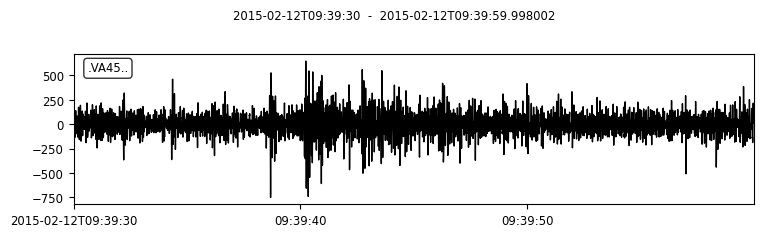

In [8]:
# Random example of noise
ls_data = ls_noise
path_data = noise_path
idx_rand = np.random.randint(0, len(ls_data))
wf = read(path_data + '/' + ls_data[idx_rand])
tr = bandfilt(wf[0])
tr.plot();

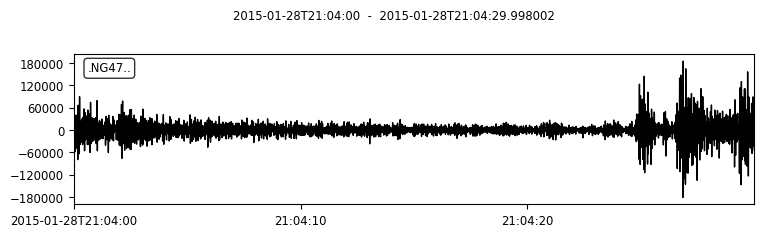

In [9]:
# Random example of seis
ls_data = ls_true_negative
path_data = true_negative_path
idx_rand = np.random.randint(0, len(ls_data))
wf = read(path_data + '/' + ls_data[idx_rand])
tr = bandfilt(wf[0])
tr.plot();

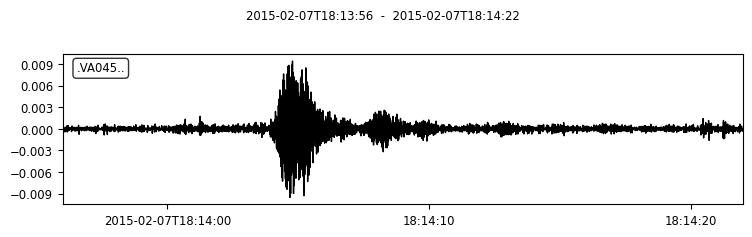

In [10]:
# Random example of Whale call
ls_data = ls_whale_call
path_data = whale_call_path
idx_rand = np.random.randint(0, len(ls_data))
wf = read(path_data + '/' + ls_data[idx_rand])
tr = bandfilt(wf[0])
tr.plot();

### Augmentations

In [11]:
save_path = data_path + '/augmentation_data'

In [12]:
def augment_whale_call(fname_whalecall):
    n_augmentations = 100
    total_augmentations = 0

    while total_augmentations != n_augmentations:
        effective_augmentations = 0

        ######################################### ORIGINAL WAVEFORM
        wc_path = whale_call_path + '/' + fname_whalecall
        wc_wf = read(wc_path)
        wc_filt = homogenizer(wc_wf[0])
        wc_filt.stats.channel = 'HHZ'
        wc_filt.stats.location = '00'
        starttime, endtime = wc_filt.stats.starttime, wc_filt.stats.endtime
        pick = starttime + wc_filt.stats['sac']['a']
        duration = endtime - starttime
        if effective_augmentations == 0:
            wc_filt.write(save_path + '/' + fname_whalecall)

        ####################################### SUPERIMPOSING NOISE or TRUE NEGATIVES
        len_noise = 0
        detrig_count = 30
        count = 0
        run_aug = np.random.randint(0, 2)
        if run_aug == 1:
            effective_augmentations += 1
            mode_ = np.random.choice(['N', 'TN'])
            wc_filt.stats.sac['user0'] = 1
            wc_filt.stats.sac['kuser0'] = mode_
            while (len_noise == 0) and (count < detrig_count):
                if mode_ == 'N':
                    idx_rand = np.random.randint(0, len(ls_noise) - 1)
                    n_path = ls_noise[idx_rand]
                    n_wf = read(noise_path + '/' + n_path)
                    n_filt = homogenizer(n_wf[0])
                if mode_ == 'TN':
                    idx_rand = np.random.randint(0, len(ls_true_negative) - 1)
                    n_path = ls_true_negative[idx_rand]
                    n_wf = read(true_negative_path + '/' + n_path)
                    n_filt = homogenizer(n_wf[0])
                    
                if len(n_filt) >= len(wc_filt):

                    sign = np.random.choice([-1, 1])
                    len_noise = len(n_filt)
                    dif = len(n_filt) - len(wc_filt)
                    idx_n_rand = sign * np.random.randint(1, dif)

                    if sign == 1:
                        noise_segment = n_filt.data[idx_n_rand:idx_n_rand+len(wc_filt)]
                    else:
                        noise_segment = n_filt.data[idx_n_rand-len(wc_filt):idx_n_rand]
                    if len(noise_segment) == 0:
                        print(idx_n_rand, len(wc_filt))
                    
                    noise_segment = noise_segment / np.max(np.sqrt(noise_segment**2))
                    
                    mean = 0.5
                    std_dev = 0.2
                    noise_level = np.clip(np.random.normal(mean, std_dev), 0.1, 0.9)

                    max_wc_amplitude = np.max(np.abs(wc_filt.data))

                    adjusted_noise_segment = noise_segment * noise_level * max_wc_amplitude

                    wc_filt.data += adjusted_noise_segment
                count += 1
        wc_filt.data /= max(wc_filt.data)

        ################################## SUPERIMPOSING OTHER WHALE CALLS
        time_window_wc = 9
        n_ev = np.random.rand()
        if n_ev <= .2:
            wc_filt.stats.sac['user1'] = 1
            wc_filt.stats.sac['kuser1'] = 'WC'
            effective_augmentations += 1
            idx_rand = np.random.randint(0, len(ls_whale_call))
            ev_path = ls_whale_call[idx_rand]
            ev_wf = read(whale_call_path + '/' + ev_path)
            ev_filt = homogenizer(ev_wf[0])
            pick_ev = ev_filt.stats.starttime + ev_filt.stats['sac']['a']
            ev_filt = ev_filt.slice(starttime=pick_ev, endtime=pick_ev+time_window_wc)
            idx_rand_pos = np.random.randint(0, len(wc_filt.data))
            dif = len(ev_filt) - len(wc_filt[idx_rand_pos:])
            mean = 1
            std_dev = 1
            noise_level = np.clip(np.random.normal(mean, std_dev), 0.5, 2)
            if dif > 0:
                wc_filt.data[idx_rand_pos:] += ev_filt.data[:-dif] / max(ev_filt.data[:-dif]) * noise_level
            else:
                wc_filt.data[idx_rand_pos:idx_rand_pos+len(ev_filt.data)] += ev_filt.data / max(ev_filt.data) * noise_level
            pick2 = wc_filt.stats.starttime + idx_rand_pos * wc_filt.stats.delta
            pick2_seconds = pick2 - wc_filt.stats.starttime
            wc_filt.stats['sac']['t0'] = pick2_seconds
            wc_filt.stats['sac']['kt0'] = 'P'
            
        if effective_augmentations > 0:
            wc_filt.data /= np.max(wc_filt.data)
            wc_filt.write(save_path + '/' + fname_whalecall.split('.')[0] + f'_{total_augmentations}.sac')
            total_augmentations += 1

run = False
if run:
    # Run in parallel
    Parallel(n_jobs=-1)(delayed(augment_whale_call)(fname_whalecall) for fname_whalecall in tqdm(ls_whale_call))


In [13]:
augmentations = os.listdir(save_path)
print(len(augmentations))

890214


In [37]:
def process_augmentation(tr):
    temp = []
    if 'kuser0' in list(tr.stats.sac.keys()):
        temp.append(tr.stats.sac.kuser0)
    if 'kuser1' in list(tr.stats.sac.keys()):
        temp.append(tr.stats.sac.kuser1)
    return temp

['N', 'WC']


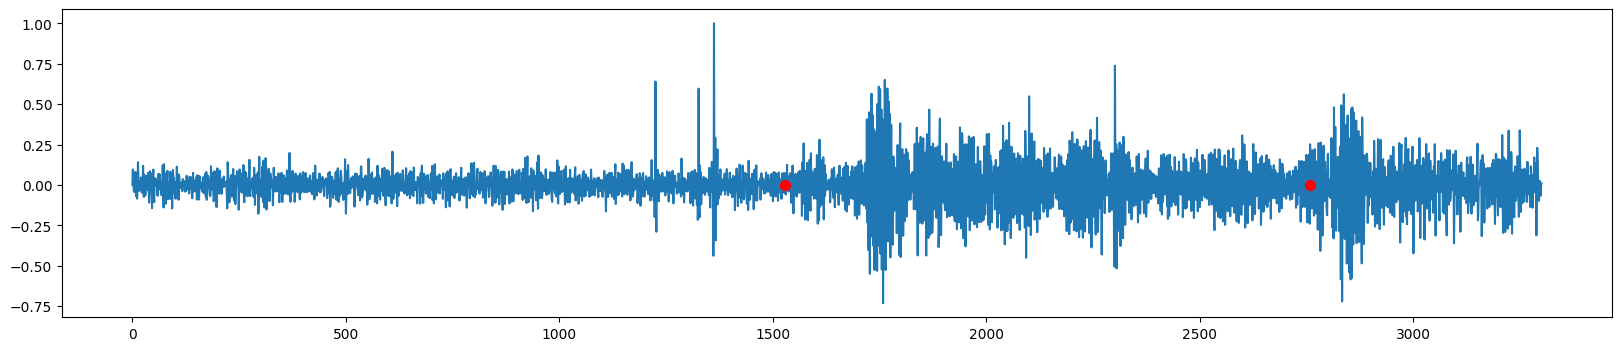

In [54]:
idx_rand = np.random.randint(0, len(augmentations) - 1)
aug = augmentations[idx_rand]
wf = read(save_path + '/' + aug)
tr = wf[0]
tmp = process_augmentation(tr)
print(tmp)
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(tr.data)
x = tr.stats.sac.a / tr.stats.delta
ax.scatter([x],[0], s=50, c='red', zorder=10) # Original pick
if 't0' in list(wf[0].stats.sac.keys()): # Second pick from augmentations (superimposing events)
    x = tr.stats.sac.t0 / tr.stats.delta
    ax.scatter([x],[0], s=50, c='red', zorder=10)
plt.show()


         network: 
         station: VA245
        location: 00
         channel: HHZ
       starttime: 2015-02-04T16:12:58.000000Z
         endtime: 2015-02-04T16:13:20.000000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 2201
           calib: 1.0
         _format: SAC
             sac: AttribDict({'delta': 0.01, 'depmin': -0.86722296, 'depmax': 1.0, 'b': 0.0, 'e': 22.0, 'a': 7.48, 'user0': 1.0, 'depmen': -3.9473057e-06, 'nzyear': 2015, 'nzjday': 35, 'nzhour': 16, 'nzmin': 12, 'nzsec': 58, 'nzmsec': 0, 'nvhdr': 6, 'npts': 2201, 'iftype': 1, 'leven': 1, 'lpspol': 0, 'lovrok': 1, 'lcalda': 0, 'unused23': 0, 'kstnm': 'VA245', 'khole': '00', 'ka': 'P', 'kuser0': 'N', 'kcmpnm': 'HHZ'})

In [15]:
def process_augmentation(aug):
    temp = []
    wf = read(save_path + '/' + aug)
    tr = wf[0]
    if 'kuser0' in list(tr.stats.sac.keys()):
        temp.append(tr.stats.sac.kuser0)
    if 'kuser1' in list(tr.stats.sac.keys()):
        temp.append(tr.stats.sac.kuser1)
    return temp

In [16]:
def get_aug_type():
    # Use Parallel to process each augmentation in parallel
    ls_aug = Parallel(n_jobs=-1)(
        delayed(process_augmentation)(aug) for aug in tqdm(augmentations)
    )
    return ls_aug

In [17]:
run = False
if run:
    ls_aug = get_aug_type()

In [18]:
# Save list to a file
run = False
if run:
    with open(data_path + '/statistics/ls_aug_type.pkl', 'wb') as file:
        pickle.dump(ls_aug, file)

In [19]:
with open(data_path + '/statistics/ls_aug_type.pkl', 'rb') as file:
    ls_aug = pickle.load(file)

In [24]:
ls_aug

[['TN'],
 ['TN'],
 ['TN'],
 ['TN'],
 ['N', 'WC'],
 ['TN'],
 ['WC'],
 ['TN'],
 ['TN', 'WC'],
 ['TN'],
 ['WC'],
 ['N'],
 ['WC'],
 ['N'],
 ['N'],
 ['N'],
 ['TN'],
 ['N'],
 ['TN'],
 ['TN'],
 ['N'],
 ['TN'],
 ['TN'],
 ['N'],
 ['WC'],
 ['WC'],
 ['WC'],
 ['TN', 'WC'],
 ['TN'],
 ['N'],
 ['TN', 'WC'],
 ['N'],
 ['WC'],
 ['TN'],
 ['N'],
 ['TN'],
 ['TN'],
 ['WC'],
 ['N'],
 ['TN'],
 ['N'],
 ['TN'],
 ['WC'],
 ['TN'],
 ['WC'],
 ['N'],
 ['TN', 'WC'],
 ['N'],
 ['N'],
 ['N'],
 ['TN'],
 ['TN'],
 ['WC'],
 ['TN'],
 ['TN'],
 ['WC'],
 ['TN'],
 ['TN', 'WC'],
 ['N', 'WC'],
 ['N', 'WC'],
 ['TN'],
 ['N'],
 ['N'],
 ['TN', 'WC'],
 ['N'],
 ['TN'],
 ['TN'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['WC'],
 ['N', 'WC'],
 ['N'],
 ['N'],
 ['N'],
 ['N', 'WC'],
 ['N', 'WC'],
 ['TN'],
 ['TN'],
 ['WC'],
 ['TN'],
 ['N'],
 ['N'],
 ['TN'],
 ['N'],
 ['TN'],
 ['WC'],
 ['N'],
 ['TN'],
 ['TN', 'WC'],
 ['N'],
 ['N'],
 ['N'],
 ['TN'],
 ['N'],
 ['N'],
 ['N'],
 ['N', 'WC'],
 ['TN', 'WC'],
 ['TN', 'WC'],
 ['WC'],
 ['TN'],
 ['TN'],
 ['TN', 'WC

In [20]:
# Convert sublists to tuples (tuples are hashable)
tuple_list = [tuple(sublist) for sublist in ls_aug]

# Count occurrences using Counter
counter = Counter(tuple_list)

# Print the result
for sublist, count in counter.items():
    print(f"{list(sublist)}: {count}")

['TN']: 293756
['N', 'WC']: 73644
['WC']: 146730
['TN', 'WC']: 73420
['N']: 293850
[]: 8814


N - Whale calls + noise only

TN - Whale calls + seismic shots

WC - Added a second whale call

[] for Original (original dataset)

Those lists with more than one augmentation type means that multiple augmentations where applied in the same original whale call.